In [31]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from tqdm import trange
from typing import Callable, Dict, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
from torch import FloatTensor
from torch.distributions import Normal  # noqa: F401
from torch.distributions import Categorical
from torch.distributions import Distribution as torchDist

from ex2mcmc import gan_distribution
from ex2mcmc.metrics.total_variation import average_total_variation
from ex2mcmc.metrics.chain import ESS, acl_spectrum, autocovariance

In [77]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

In [99]:
class SamplableDistribution(gan_distribution.Distribution):

    @abstractmethod
    def sample(self, sample_count) -> FloatTensor:
        pass

class GaussianMixture(SamplableDistribution):
    def __init__(self, means, covs, weights):
        self.weights = FloatTensor(weights)
        self.category = torch.distributions.Categorical(self.weights)
        self.means = means
        self.covs = covs

    def sample(self, sample_count: int) -> FloatTensor:
        which_gaussian = self.category.sample((sample_count,))
        multivariate_normal = torch.distributions.MultivariateNormal(
            self.means[which_gaussian], self.covs[which_gaussian])
        
        return FloatTensor(multivariate_normal.sample())
    
    def log_prob(self, z: FloatTensor) -> FloatTensor:
        logs = torch.distributions.MultivariateNormal(self.means, self.covs).log_prob(z[:, None, :])
        return FloatTensor(torch.log(torch.exp(logs) @ self.weights))

In [97]:
def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    
    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = np.array(ot.dist(xs_true / scale, xs_pred[:, b] / scale))
        emd = ot.lp.emd2([], [], M, numItermax=1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [85]:
def heuristics_step_size(
    mean_acceptance: float,
    target_acceptance: float,
    step_size: float,
    factor: float = 1.05,
    tol: float = 0.03,
):
    if mean_acceptance - target_acceptance > tol:
        return step_size * factor
    if target_acceptance - mean_acceptance > tol:
        return step_size / factor
    return step_size

def mala(
    start: torch.FloatTensor,
    target: Union[SamplableDistribution, torchDist],
    proposal: Union[SamplableDistribution, torchDist],
    n_samples: int,
    burn_in: int,
    project: Callable = lambda x: x,
    *,
    step_size: float,
    verbose: bool = False,
    target_acceptance=None,
    meta: Optional[Dict] = None,
    keep_graph: bool = False,
) -> Tuple[torch.FloatTensor, Dict]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, meta
    """
    if n_samples + burn_in <= 0:
        raise ValueError("Number of steps might be positive")

    chains = []
    point = start.clone()
    point.requires_grad_()
    point.grad = None

    device = point.device

    # Reassigning of the argument proposal
    proposal = torch.distributions.MultivariateNormal(
        torch.zeros(point.shape[-1], device=device),
        torch.eye(point.shape[-1], device=device),
    )

    meta = meta or dict()
    meta["mh_accept"] = meta.get("mh_accept", [])
    meta["step_size"] = meta.get("step_size", [])
    meta["logp"] = logp_x = target.log_prob(point)

    if "grad" not in meta:
        if keep_graph:
            grad_x = torch.autograd.grad(
                meta["logp"].sum(),
                point,
                create_graph=keep_graph,
                retain_graph=keep_graph,
            )[0]
        else:
            grad_x = torch.autograd.grad(logp_x.sum(), point)[0].detach()
        meta["grad"] = grad_x
    else:
        grad_x = meta["grad"]

    pbar = trange if verbose else range
    for step_id in pbar(n_samples + burn_in):
        noise = proposal.sample(point.shape[:-1])
        proposal_point = point + step_size * grad_x + noise * (2 * step_size) ** 0.5
        proposal_point = project(proposal_point)
        if not keep_graph:
            proposal_point = proposal_point.detach().requires_grad_()

        logp_y = target.log_prob(proposal_point)
        grad_y = torch.autograd.grad(
            logp_y.sum(),
            proposal_point,
            create_graph=keep_graph,
            retain_graph=keep_graph,
        )[
            0
        ]  # .detach()

        log_qyx = proposal.log_prob(noise)
        log_qxy = proposal.log_prob(
            (point - proposal_point - step_size * grad_y) / (2 * step_size) ** 0.5
        )

        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob
        mask = mask.detach()

        if keep_graph:
            mask_f = mask.float()
            point = point * (1 - mask_f)[:, None] + proposal_point * mask_f[:, None]
            logp_x = logp_x * (1 - mask_f) + logp_y * mask_f
            grad_x = grad_x * (1 - mask_f)[:, None] + grad_y * mask_f[:, None]
        else:
            with torch.no_grad():
                point[mask, :] = proposal_point[mask, :]
                logp_x[mask] = logp_y[mask]
                grad_x[mask] = grad_y[mask]

        meta["mh_accept"].append(mask.float().mean().item())
        if target_acceptance:
            step_size = heuristics_step_size(
                meta["mh_accept"][-1], target_acceptance, step_size
            )
        meta["step_size"].append(step_size)

        if not keep_graph:
            point = point.detach().requires_grad_()
        if step_id >= burn_in:
            chains.append(point.cpu().clone())
    chains = torch.stack(chains, 0)

    meta["logp"] = logp_x
    meta["grad"] = grad_x
    meta["mask"] = mask.detach().cpu()

    return chains, meta

In [109]:
@dataclass
class Benchmark:
    target_dist: gan_distribution.Distribution
    target_title: str
    sampling_algorithm: Callable
    sample_count: int

    def _plot_samples(self, ax: plt.Axes, samples: FloatTensor, title: str) -> None:
        ax.scatter(samples[:, 0], samples[:, 1])
        ax.set_title(title)

    def plot_samples(self, chains_count: int) -> None:
        if isinstance(self.target_dist, SamplableDistribution):
            fig, axes = plt.subplots(nrows=chains_count+1, ncols=1, figsize=(5, 5*(chains_count+1)))
            true_samples = self.target_dist.sample(self.sample_count)
            self._plot_samples(axes[0], true_samples, self.target_title)
        else:
            fig, axes = plt.subplots(nrows=chains_count, n_cols=1, figsize=(5, 5*chains_count))

    def run(self) -> dict:
            
        self.plot_samples(2)
        return {}

In [110]:
means = torch.tensor([[0., 0.], [10., 10.]])
covs = torch.tensor(
    [[[1., 0], [0, 1.]],
    [[1., 0], [0, 1.]]])

sample_count = 1000
gm = GaussianMixture(means, covs, [0.5, 0.5])
benchmark = Benchmark(
    target_dist=gm,
    target_title="true samples 0.5 $\mathcal{N}(0, I) + 0.5\mathcal{N}((10, 10), I)$",
    sampling_algorithm=mala, 
    sample_count=sample_count)

{}

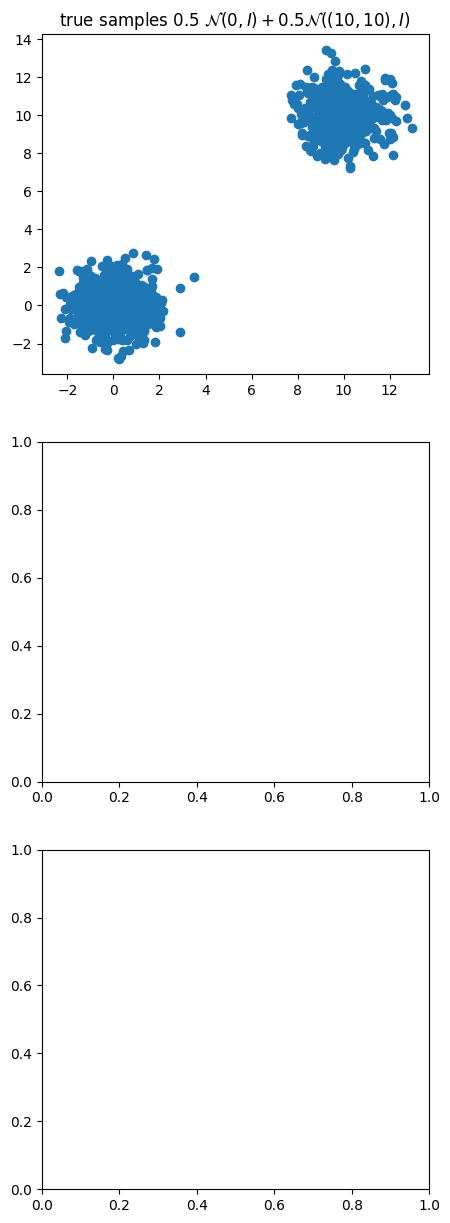

In [111]:
benchmark.run()

In [52]:
start = FloatTensor([[0, 0], [2, 2]])
target = gm

mcmc_samples = mala(start, target, None, n_samples=1000, burn_in=1000, step_size=0.5,
                    keep_graph=False)[0].detach()

In [54]:
compute_metrics(jnp.array(samples),
                jnp.array(mcmc_samples), name="MALA", trunc_chain_len=0)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

====MALA====
TV distance. Mean: 0.510, Std: 0.107. 
ESS: 0.169 
EMD: 87.270


{'ess': 0.16919735,
 'tv_mean': Array(0.5104867, dtype=float32),
 'tv_conf_sigma': Array(0.01503485, dtype=float32),
 'emd': 87.81740863113113}

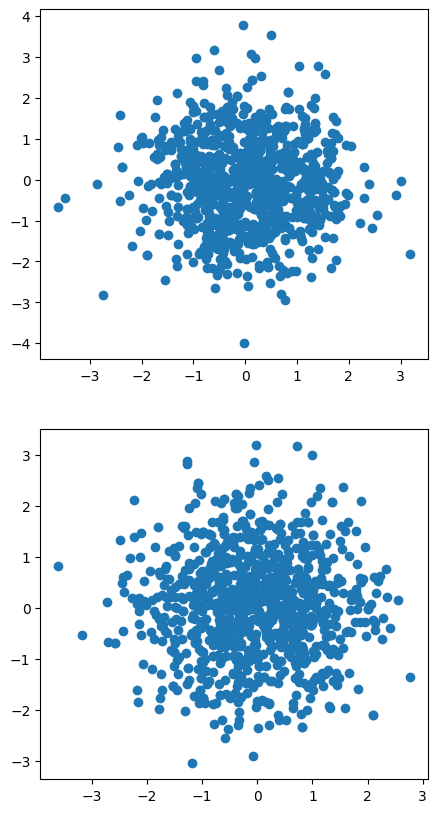

In [55]:
fig, axes = plt.subplots(start.shape[0], 1, figsize=(5, 10))

for i, ax in enumerate(axes):
    ax.scatter(mcmc_samples[:, i, 0], mcmc_samples[:, i, 1])